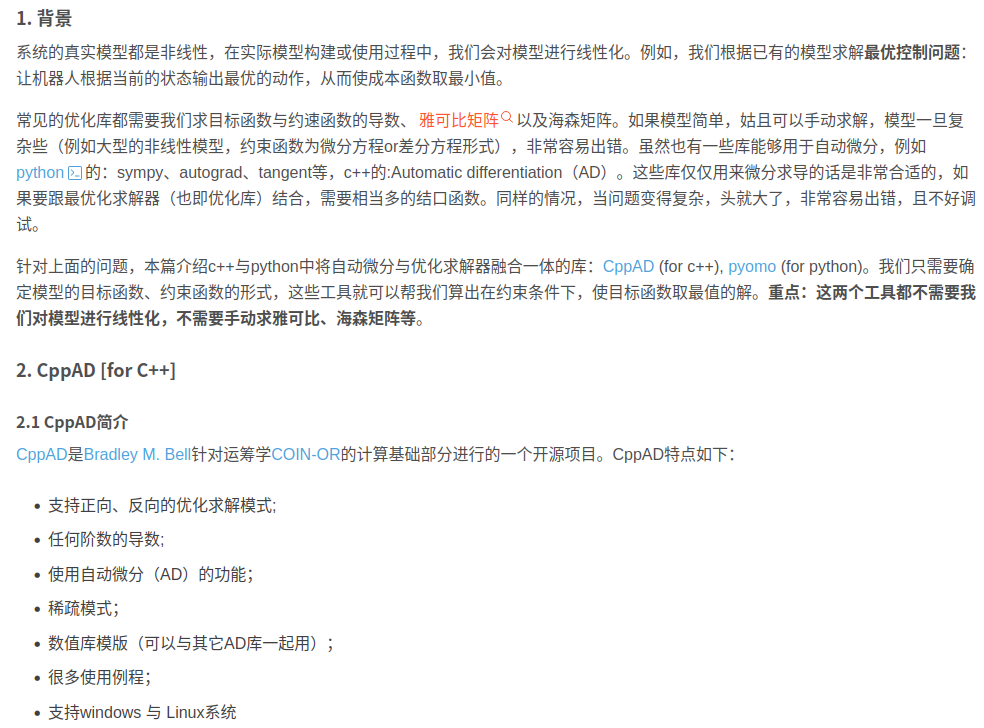

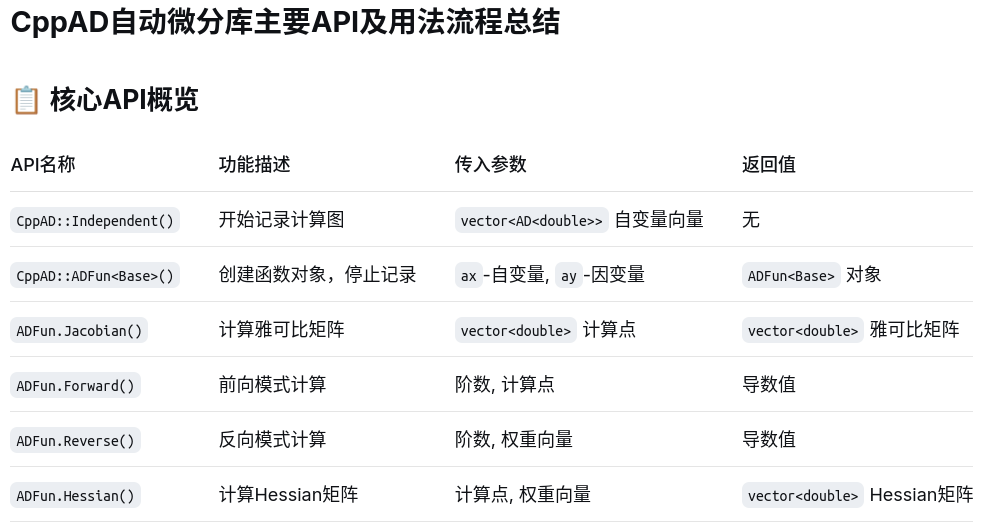  


主要API详细说明

1. CppAD::Independent(ax)

    功能：开始记录计算操作序列

    参数：vector<AD\<double\>> ax - 自变量向量

    说明：此后所有使用AD\<double\>类型的操作都会被记录

2. CppAD::ADFun\<Base\>(ax, ay)

    功能：停止记录并创建函数对象

    参数：

        ax - 自变量向量 vector<AD<Base>>

        ay - 因变量向量 vector<AD<Base>>

    返回值：ADFun\<Base\>对象，封装完整的计算图

3. f.Jacobian(x)

    功能：计算雅可比矩阵

    参数：vector\<double\> x - 计算点的坐标

    返回值：vector\<double\> - 按行存储的雅可比矩阵

4. f.Forward(p, xp)

    功能：前向模式计算导数

    参数：

        p - 导数阶数（0=函数值，1=一阶导等）

        xp - 计算方向的向量

    返回值：vector\<double\> - 导数值

    说明：适合计算少数方向上的高阶导数

5. f.Reverse(p, w)

    功能：反向模式计算导数

    参数：

        p - 导数阶数

        w - 权重向量

    返回值：vector\<double\> - 导数值

    说明：适合计算多个变量的梯度

6. f.Hessian(x, w)

    功能：计算Hessian矩阵

    参数：

        x - 计算点

        w - 权重向量（用于标量函数）

    返回值：vector\<double\> - Hessian矩阵（按行存储）

7. f.optimize()

    功能：优化计算图，提高稀疏计算效率

    时机：在构建完计算图后，进行稀疏计算前调用

    效果：可以显著减少内存使用和计算时间

计算流程如下  
准备自变量并开始记录计算图  

所有后续使用AD<double>类型的计算都会被记录

ax向量中的值作为计算图的输入节点，注意ax只能用于一个计算图的构建，不能被修改，否则ax对应的计算图会崩掉，  
如果要新建一个计算图，必须新建一个使用其他的变量名的变量

In [ ]:
vector<AD<double>> ax(n);
/* n是自变量向量维度
需要对ax进行初始化赋值
例如：*/
ax[0]=0;
// 开始记录计算操作序列
CppAD::Independent(ax);          // 开始构建计算图

注意：记录阶段只是构建计算图，不进行实际数值计算。ax 的初始值主要用于：

    确定变量的维度

    在某些情况下帮助类型推导

    构建完整的计算图结构

也就是说ax初始为什么值都可以，实际计算在某一点的导数由后面指定的x确定  
虽然 ax 的初始值可以是任意的，但需要确保：

    不引起未定义行为（如除零、负数开平方等）

    在函数的定义域内

定义并计算因变量  

使用标准的数学运算符和函数

CppAD会自动重载这些操作来记录计算图

In [ ]:
vector<AD<double>> ay(m);        // 因变量向量

ay=function(ax);                //自定义计算公式

// 例如
vector<AD<double>> function(vector<AD<double>> X){
    Y=f(X); //一堆运算

    return Y;
}

注意，这里使用函数来定义ay是如何由ax计算而来，这个函数可以是值传递的，返回也不需要是引用，但是建议使用如下的形式：  

    vector<AD<double>> function(const vector<AD<double>>& X)

    void function(const vector<AD<double>>& X,vector<AD<double>>& Y)

在CppAD中使用诸如sin、abs、sqrt等数学函数时，必须使用CppAD封装的版本，不能直接使用C++标准库中的函数。   

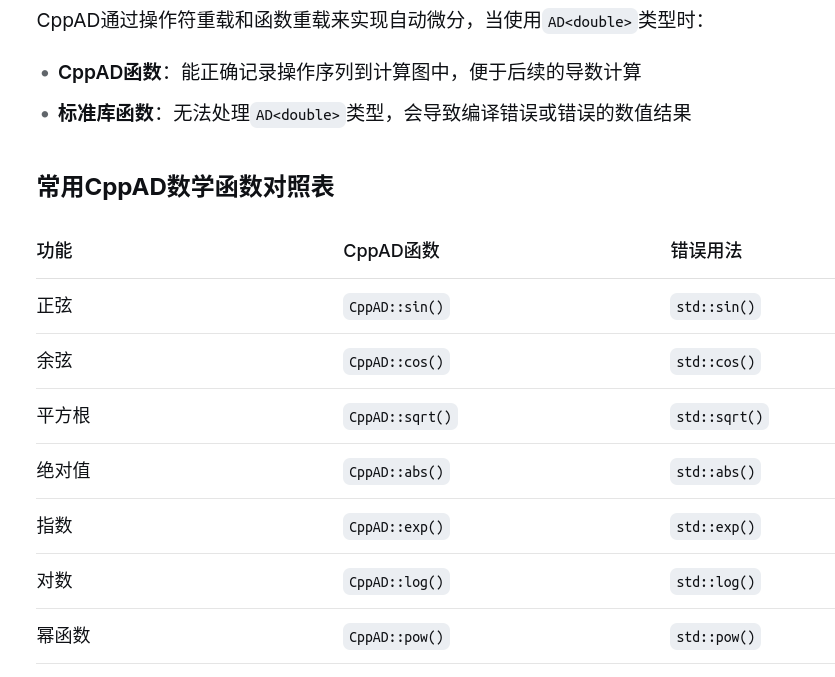

<pre>CppAD支持丰富的数学函数，主要包括：

    基本函数：sin, cos, tan, asin, acos, atan

    双曲函数：sinh, cosh, tanh

    指数和对数：exp, log, log10

    幂函数：sqrt, pow

    绝对值：abs, fabs

    取整函数：ceil, floor

停止记录并创建函数对象  

    此时计算图记录完成

    f对象包含了从ax到ay的所有计算信息

In [ ]:
// 创建ADFun对象，封装完整的计算图
CppAD::ADFun<double> f(ax, ay);  // f: X → Y

准备计算点并计算导数  

计算阶段的 x 值决定实际计算导数的具体点

这个过程可以指定多次，都用的第一次构建的计算图，修改求导点x再次使用f.Jacobian(x)即可

In [ ]:
// 设置计算导数的点
vector<double> x(n);             // 计算点向量（使用普通double类型）
x[0] = 2.0;                      // 要在x=2.0处计算导数

// 计算导数（雅可比矩阵）
vector<double> jac = f.Jacobian(x);  // 计算导数f'(x)

//按行存储的雅可比矩阵

使用计算结果  


In [ ]:
// 输出或使用导数结果
std::cout << "f'(" << x[0] << ") = " << jac[0] << std::endl;

// 验证：对于f(x)=3x²+2x+1，f'(x)=6x+2，在x=2处f'(2)=14

对于向量值函数 F: ℝⁿ → ℝᵐ：
$$\vec y=f(\vec x)=F(x₁, x₂, ..., xₙ) = [f₁(\vec x), f₂(\vec x), ..., fₘ(\vec x)]^T \quad \vec x \in R^n ,\vec y \in R^m$$
雅可比矩阵 J 是一个 m×n 矩阵：  
$$J=\begin{bmatrix} \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} &...&\frac{\partial f_1}{\partial x_n}
\\ \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} &...&\frac{\partial f_2}{\partial x_n}
\\ ...&...&...&...
\\ \frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} &...&\frac{\partial f_m}{\partial x_n}
\end{bmatrix}$$
多输出函数，需要分别计算每个输出分量的Hessian，即输出维度是$m \times n \times n$
即取出雅可比矩阵的每一行转置后对输入$\vec x$求jacobian  
$$\begin{bmatrix} \frac{\partial f_i}{\partial x_1} & \frac{\partial f_i}{\partial x_2} &...&\frac{\partial f_i}{\partial x_n}\end{bmatrix}^T$$

等价于标量函数 f: ℝⁿ → ℝ的Hessian矩阵(n×n 对称矩阵)：
$$H=\begin{bmatrix} \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} &...&\frac{\partial^2 f}{\partial x_1 \partial x_n}
\\\frac{\partial^2 f}{\partial x_2^2} & \frac{\partial^2 f}{\partial x_2^2 } &...&\frac{\partial^2 f}{\partial x_2 \partial x_n}
\\ ...&...&...&...
\\\frac{\partial^2 f}{\partial x_n^2} & \frac{\partial^2 f}{\partial x_n \partial x_2} &...&\frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}$$


In [ ]:
vector<double> hessian_f1 = f.Hessian(x, w_f1);

x代表在哪一点求hessian，w_f1表示对于m个$n \times n$的hessian，使用什么样的比例加和成$n \times n$的输出  
权重向量 w 定义了一个标量函数：

$g(x) = w₁·f₁(x) + w₂·f₂(x) + ... + wₘ·fₘ(x)$

Hessian矩阵计算的是这个组合标量函数 g(x) 的二阶导数。

在计算得到jacobian矩阵后，可以直接定义二阶导数点和权重直接求hessian矩阵

In [ ]:
vector<double> w_f2(2);
w_f2[0] = 0.0;  // f1的权重（忽略）
w_f2[1] = 1.0;  // f2的权重
vector<double> hessian = f.Hessian(x, w_f2);

对于向量值函数 F: ℝⁿ → ℝᵐ：
$$\vec y=f(\vec x)=F(x₁, x₂, ..., xₙ) = [f₁(\vec x), f₂(\vec x), ..., fₘ(\vec x)]^T \quad \vec x \in R^n ,\vec y \in R^m$$

当输出$f_i(\vec x)$只依赖于几个x,如$x_p,x_j,x_k,...$
那么$\frac{\partial f_i}{\partial x_e}=0 \quad x_e \notin j,k,p,...$
jacobian矩阵就有很多地方是0



优化和稀疏模式检测  
如果 n < m（自变量少，因变量多），使用前向模式（ForSparseJac）更高效。  
如果 n > m（自变量多，因变量少），使用反向模式（RevSparseJac）更高效。  

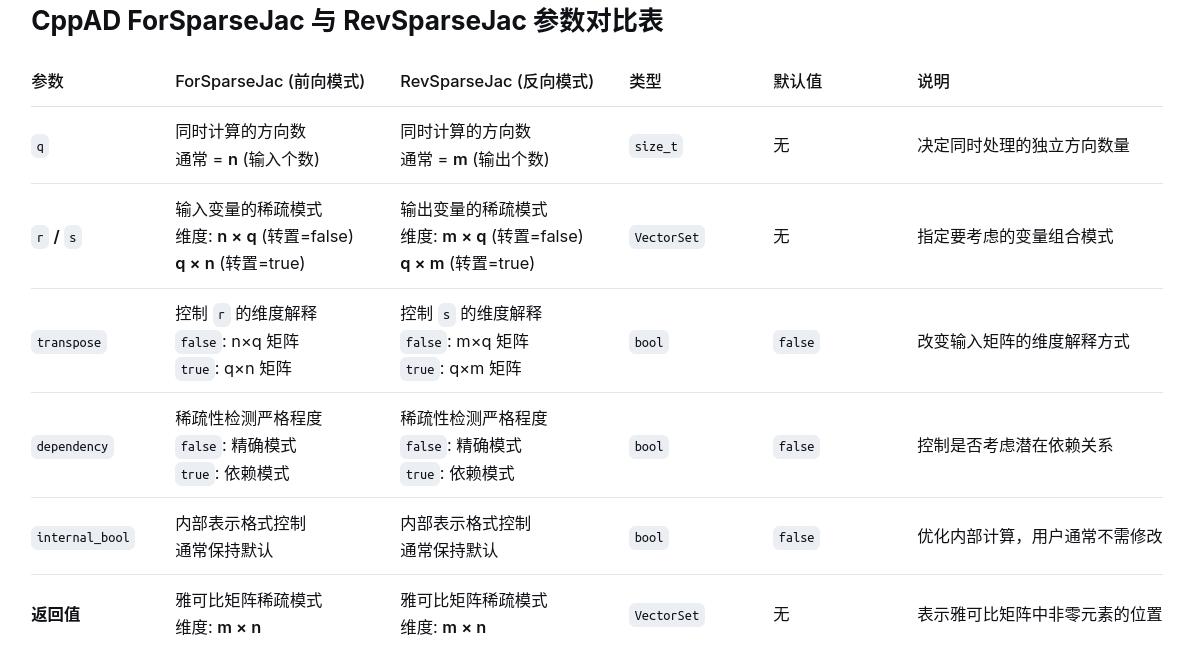
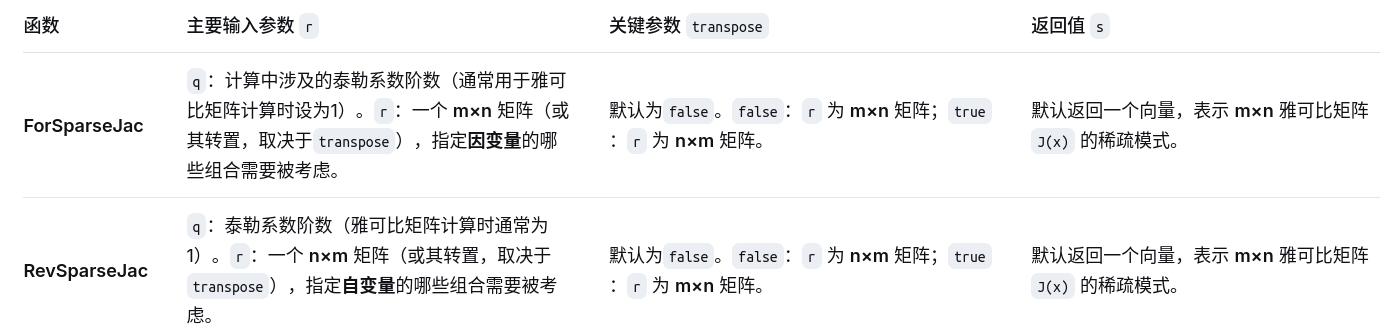

参数 r/s 与依赖关系：
$$J=\begin{bmatrix} \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} &...&\frac{\partial f_1}{\partial x_n}
\\ \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} &...&\frac{\partial f_2}{\partial x_n}
\\ ...&...&...&...
\\ \frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} &...&\frac{\partial f_m}{\partial x_n}
\end{bmatrix}$$

在 ForSparseJac 中，它指定了在输入空间中，对于某个输出$\partial f_i$,我们关心输入方向$\vec x$的分量的组合。  
例如，如果r的第j列只有一个非零元素在第i行，那么这意味着我们关心第i个输入变量变化时对输出的影响（即雅可比矩阵的第i列）。  
如果我们使用单位矩阵，那么每一列对应一个输入变量，我们将得到完整的雅可比矩阵的稀疏模式。  

    ForSparseJac(q, r) 计算的是：J * r 的稀疏模式，其中：  
    J 是 m×n 的雅可比矩阵  
    r 是 n×q 的输入模式矩阵  
    结果是 m×q 的稀疏模式矩阵  
$$\begin{bmatrix} \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} &...&\frac{\partial f_1}{\partial x_n}
\\ \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} &...&\frac{\partial f_2}{\partial x_n}
\\ ...&...&...&...
\\ \frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} &...&\frac{\partial f_m}{\partial x_n}
\end{bmatrix}\begin{bmatrix} 1 & 0 &...&0
\\ 0 & 1 &...&0
\\ ...&...&...&...
\\ 0 & 0 &...&1
\end{bmatrix}$$

在 RevSparseJac 中，它指定了在输出空间中，对于某个输入$x_i$,我们关心输出方向$ \partial \vec y$的分量的组合。  
例如，如果s的第j列只有一个非零元素在第i行，那么这意味着我们关心第i个输出变量对输入变量的导数（即雅可比矩阵的第i行）。  
如果我们使用单位矩阵，那么每一列对应一个输出变量，我们将得到完整的雅可比矩阵的稀疏模式。  

    RevSparseJac(q, s) 计算的是：sᵀ * J 的稀疏模式，其中：  
    J 是 m×n 的雅可比矩阵  
    s 是 m×q 的输出模式矩阵  
    sᵀ 是 s 的转置 (q×m)  
    结果是 q×n 的稀疏模式矩阵  
$$\begin{bmatrix} 1 & 0 &...&0
\\ 0 & 1 &...&0
\\ ...&...&...&...
\\ 0 & 0 &...&1
\end{bmatrix}\begin{bmatrix} \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} &...&\frac{\partial f_1}{\partial x_n}
\\ \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} &...&\frac{\partial f_2}{\partial x_n}
\\ ...&...&...&...
\\ \frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} &...&\frac{\partial f_m}{\partial x_n}
\end{bmatrix}$$

通常设置r/s为单位矩阵来获取J的稀疏模式，那么两种方式输出都是J的稀疏模式，m*n

In [ ]:
CppAD::ADFun<double> f(ax, ay);
f.optimize();  // 优化计算图，提高稀疏计算效率

// 创建单位矩阵作为输入模式
vector<bool> r(n * n);
for(size_t i = 0; i < n; i++) {
    for(size_t j = 0; j < n; j++) {
        r[i * n + j] = (i == j); // 单位矩阵
    }
}

// 计算雅可比矩阵的稀疏模式
vector<bool> pattern = f.ForSparseJac(n, r);

稀疏雅可比计算  

CppAD::sparse_jacobian_work 结构体

可以把 sparse_jacobian_work 看作是为稀疏雅可比计算预存"攻略"和"草稿纸"的工作区：

    主要作用：存储计算稀疏雅可比矩阵所需的信息，以便在多次计算时复用，避免重复分析计算图。

    关键成员：它内部会保存像矩阵着色等信息，这能确定计算非零元素的最佳顺序。

    使用场景：当你需要多次计算同一函数对象在不同点上的稀疏雅可比矩阵时，使用此工作结构体可以显著提升效率。


In [ ]:
CppAD::sparse_jacobian_work work;

// 提取非零元素的位置
vector<size_t> row, col;
for(size_t i = 0; i < m; i++) {
    for(size_t j = 0; j < n; j++) {
        if(pattern[i * n + j]) {
            row.push_back(i);
            col.push_back(j);
        }
    }
}
size_t K = row.size(); // 非零元素个数
vector<double> jac(K);    // 存储雅可比矩阵的非零值

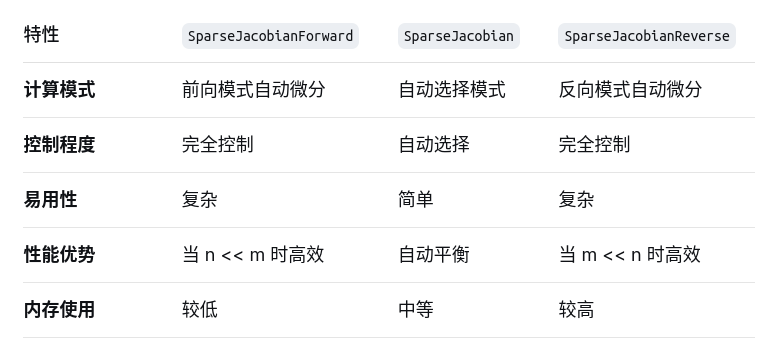  

f.SparseJacobianReverse() 与 f.SparseJacobianReverse()函数

这个函数则是执行稀疏雅可比矩阵计算的"主力队员"。

    功能：使用反向模式自动微分，并结合稀疏性，计算函数在给定点 x 处的雅可比矩阵的非零元素。
    返回值：size_t，计算使用的扫描次数

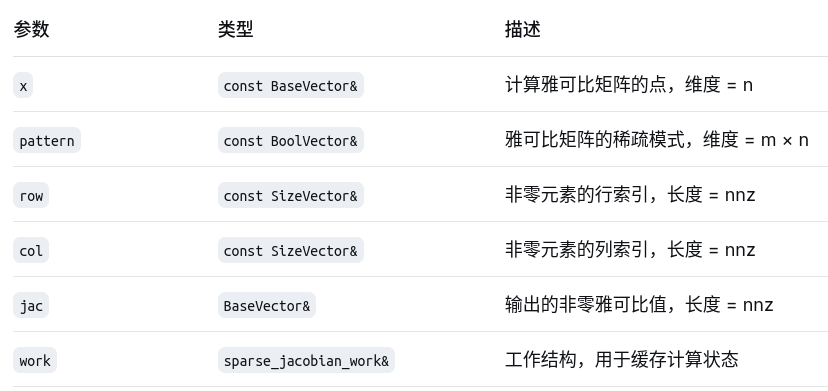

模式选择：选择前向 (SparseJacobianForward) 还是反向 (SparseJacobianReverse) 模式，取决于函数输入维度 n 和输出维度 m 的相对大小。  
当 n 远大于 m 时，反向模式通常更高效。

vector\<double\> SparseJacobian(x,pattern)

<pre>    x	    const BaseVector&	计算雅可比矩阵的点，维度 = n  
pattern	    const BoolVector&	可选的稀疏模式，维度 = m × n  
返回值：  
    返回完整的雅可比矩阵（稠密格式）  
    维度 = m × n，但只计算稀疏模式指示的非零元素  

In [ ]:
// 使用稀疏模式计算雅可比
vector<double> x(n);
for(size_t i = 0; i < n; i++) x[i] = double(i + 1);

// 对于输入少输出多的问题，使用反向模式
if (n < m) {
    size_t n_sweep = f.SparseJacobianReverse(x, pattern, row, col, jac, work);
} 
// 对于输入多输出少的问题，使用前向模式  
else {
    size_t n_sweep = f.SparseJacobianForward(x, pattern, row, col, jac, work);
}
vector<double> jac1 = f.SparseJacobian(x);
vector<double> jac2 = f.SparseJacobian(x, pattern);
// 返回的是一整个jacobian矩阵

稀疏Hessian计算  

检测Hessian稀疏模式  

如果 n < m（自变量少，因变量多），使用前向模式（ForSparseHes）更高效。  
如果 n > m（自变量多，因变量少），使用反向模式（RevSparseHes）更高效。  

ForSparseHes 函数详解：  
vector<bool> ForSparseHes(const vector<bool>& select_domain, const vector<bool>& select_range)  

    功能：使用前向模式自动检测Hessian矩阵的稀疏模式

    参数：

        select_domain：布尔向量，指定哪些自变量需要考虑

        select_range - 输出选择向量，指定要计算哪个输出函数的Hessian矩阵

    返回值：n×n 的布尔矩阵（按行存储），true 表示该位置可能非零

In [ ]:
vector<bool> select_domain(num_inputs, true);
vector<bool> select_range(num_outputs, false);
select_range[output_idx] = true;  // 选择当前输出

vector<bool> sparsity = func.ForSparseHes(select_domain, select_range);

计算稀疏Hessian  

SparseHessian 函数详解：

    功能：计算稀疏Hessian矩阵的非零元素

    参数：

        x：计算点

        w：权重向量

        hessian_sparsity：稀疏模式

        row, col, val：输出参数，存储非零元素信息

        work：工作结构，优化重复计算

In [ ]:
// 计算稀疏Hessian
    vector<double> x(n);
    
    // 设置计算点
    
    CppAD::sparse_hessian_work work;  // 工作结构，用于优化重复计算
    vector<size_t> row, col;           // 存储非零元素的行列索引
    vector<double> val;                // 存储非零元素的值
    
    f.SparseHessian(x, w, hessian_sparsity, row, col, val, work);

更高阶的导数计算可以使用Forward(q,dx)  

$$f(x + dx) ≈ f(x) + f'(x)dx + \frac{1}{2!}*f''(x)*dx^2 + ...$$
q表示阶数，  
q = 0：计算函数值 $F(x)$  
q = 1：计算一阶方向导数 $f'(x) \cdot dx$  
q = 2：计算二阶泰勒系数 $\frac{1}{2!} f''(x) \cdot dx^2$  
q = k：计算k阶泰勒系数 $\frac{1}{k!} f^{(k)}(x) \cdot dx^k$  

参数 dx - 方向向量,数学含义：  
对于 q = 0：计算点 $x$（此时 dx 实际上是计算点）  
对于 q ≥ 1：方向向量，指定导数的计算方向  
dx.size() == n（输入变量的个数） 


返回值 dy - 泰勒系数向量,数学含义：  

包含函数在各阶方向上的泰勒系数  
对于向量值函数 $F: \mathbb{R}^n \rightarrow \mathbb{R}^m$，返回m维向量  
具体内容：  
q = 0：dy[i] = $f_i(x)$（第i个输出分量的函数值）  
q = 1：dy[i] = $\nabla f_i(x) \cdot dx$（第i个输出分量在dx方向上的方向导数）  
q = 2：dy[i] = $\frac{1}{2!} dx^T_{1 \times n} \cdot \nabla^2 f_i(x)_{n \times n} \cdot dx_{n \times 1}$（二阶泰勒系数）  
q = 3: dy[i] = $\frac{1}{3!}\sum\limits_{i,j,k=1}^{n}\frac{\partial^3 F_i}{\partial x_j \partial x_k \partial x_l}dx_idx_jdx_k$一般用不到   
维度：  
dy.size() == m（输出变量的个数）  


In [ ]:
CPPAD_TESTVECTOR(Base) ADFun<Base>::Forward(
    size_t               q,     // 泰勒系数的阶数
    const BaseVector&    dx     // 方向向量
)

// 计算在x方向上的导数
dx = [1, 0, 0, ..., 0]
// 计算在y方向上的导数  
dx = [0, 1, 0, ..., 0]
// 计算在组合方向上的导数
dx = [0.5, 0.5, 0, ..., 0]  // 在x和y的平分角方向